# Date Preprocessing for EWMA Matlab

In [1]:
import pandas as pd
import numpy as np

In [2]:
# data from 2017.1.1 to 2021.3.28
btc = pd.read_csv('data/BTC-USD.csv')
eth = pd.read_csv('data/ETH-USD.csv')
xrp = pd.read_csv('data/XRP-USD.csv')

In [3]:
# only using adj close data
btc_price = btc['Adj Close']
eth_price = eth['Adj Close']
xrp_price = xrp['Adj Close']

In [4]:
date_array = btc['Date'].to_numpy()

In [5]:
# convert price to returns and adjust length
# e.g. 1.1 $100, 1.2 : $120, return: 1.1 with ln(120) - ln(100)
return_btc = np.diff(np.log(btc_price), n=1, axis=0)
return_eth = np.diff(np.log(eth_price), n=1, axis=0)
return_xrp = np.diff(np.log(xrp_price), n=1, axis=0)

In [6]:
return_dataset = pd.DataFrame({'Date': date_array[0:-1], 'btc': return_btc, 'eth': return_eth, 'xrp': return_xrp})

In [7]:
return_dataset['btc'].isnull().values.any()

True

In [8]:
return_dataset[return_dataset['btc'].isnull()]

,Date,btc,eth,xrp
1200,2020-04-16,NaN,NaN,NaN
1201,2020-04-17,NaN,NaN,NaN
1375,2020-10-08,NaN,NaN,NaN
1376,2020-10-09,NaN,NaN,NaN
1378,2020-10-11,NaN,NaN,NaN
1379,2020-10-12,NaN,NaN,NaN
1380,2020-10-13,NaN,NaN,NaN


In [9]:
# dropna
return_dataset = return_dataset.dropna()

In [10]:
return_dataset['btc'].isnull().values.sum() + return_dataset['eth'].isnull().values.sum() + return_dataset['xrp'].isnull().values.sum() == 0

True

In [11]:
len(return_dataset) 

1540

In [17]:
return_dataset.to_csv('returns.csv', index=False)  

# Garch 1,1 Model

In [24]:
import numpy as np
import scipy
import pandas as pd
class garchOneOne(object):
       
    def __init__(self, logReturns):
        self.logReturns = logReturns
        self.sigma_2 = self.garch_filter(self.garch_optimization())
        self.coefficients = self.garch_optimization()
        
    def garch_filter(self, parameters):
        "Returns the variance expression of a GARCH(1,1) process."
        
        # Slicing the parameters list
        omega = parameters[0]
        alpha = parameters[1]
        beta = parameters[2]
        
        # Length of logReturns
        length = len(self.logReturns)
        
        # Initializing an empty array
        sigma_2 = np.zeros(length)
        
        # Filling the array, if i == 0 then uses the long term variance.
        for i in range(length):
            if i == 0:
                sigma_2[i] = omega / (1 - alpha - beta)
            else:
                sigma_2[i] = omega + alpha * self.logReturns[i-1]**2 + beta * sigma_2[i-1]
        
        return sigma_2 
        
    def garch_loglikehihood(self, parameters):
        "Defines the log likelihood sum to be optimized given the parameters."
        length = len(self.logReturns)
        
        sigma_2 = self.garch_filter(parameters)
        
        loglikelihood = - np.sum(-np.log(sigma_2) - self.logReturns**2 / sigma_2)
        return loglikelihood
    
    def garch_optimization(self):
        "Optimizes the log likelihood function and returns estimated coefficients"
        # Parameters initialization
        parameters = [.1, .05, .92]
        
        # Parameters optimization, scipy does not have a maximize function, so we minimize the opposite of the equation described earlier
        opt = scipy.optimize.minimize(self.garch_loglikehihood, parameters,
                                     bounds = ((.001,1),(.001,1),(.001,1)))
        
        variance = .01**2 * opt.x[0] / (1 - opt.x[1] - opt.x[2])   # Times .01**2 because it concerns squared returns
        
        return np.append(opt.x, variance)

In [25]:
from arch import arch_model
import matplotlib.pyplot as plt

In [26]:
def run_garch(data,cryptoType, conf_interval):
    print("="*40)
    print("="*40)
    print ("Running Garch 1,1 model for %s" %cryptoType)
    model = garchOneOne(data)
    arch_m = arch_model(data, mean = 'Zero', vol = 'GARCH')
    arch_m = arch_m.fit()
    conf_int = pd.DataFrame(arch_m.conf_int(alpha = conf_interval))
    conf_int['garchOneOne'] = model.coefficients[:-1]
    conf_int['Test'] = np.where(conf_int['garchOneOne'] < conf_int['upper'], np.where(conf_int['garchOneOne'] > conf_int['lower'], "Ok", "Not ok"), "Not ok") 
    print("conf_int for %s" %cryptoType)
    print(conf_int)
    
    %matplotlib inline
    df = pd.DataFrame(np.sqrt(model.sigma_2))
    print(df.head())
    # Plotting the data
    plt.plot(df, label = ' GARCH(1,1)', linewidth = .75)
    plt.legend()
    plt.title('GARCH(1,1) processes of %s' %cryptoType, fontweight = 'bold')
    return model.sigma_2

Running Garch 1,1 model for BTC
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4018515.218934022
Iteration:      2,   Func. Count:     11,   Neg. LLF: -2660.05848579102
Iteration:      3,   Func. Count:     17,   Neg. LLF: -1545.4172201787667
Iteration:      4,   Func. Count:     22,   Neg. LLF: -2728.2596470486496
Iteration:      5,   Func. Count:     27,   Neg. LLF: -2721.7286051459887
Iteration:      6,   Func. Count:     32,   Neg. LLF: -2580.1332642257266
Iteration:      7,   Func. Count:     37,   Neg. LLF: -2764.5978703684464
Iteration:      8,   Func. Count:     41,   Neg. LLF: -2764.6385118201106
Iteration:      9,   Func. Count:     45,   Neg. LLF: -2764.645700886025
Iteration:     10,   Func. Count:     49,   Neg. LLF: -2764.647337086943
Iteration:     11,   Func. Count:     53,   Neg. LLF: -2764.6474164790993
Iteration:     12,   Func. Count:     57,   Neg. LLF: -2764.647415251861
Optimization terminated successfully    (Exit mode 0)
            Current function valu

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001831. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


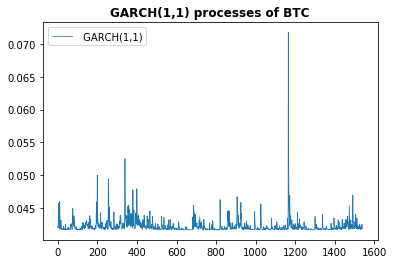

In [30]:
btc_sigma = run_garch(return_dataset.btc.to_numpy(), "BTC", 0.05)

Running Garch 1,1 model for ETH
Iteration:      1,   Func. Count:      4,   Neg. LLF: -2330.9549992592774
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2330.9550013204953
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
conf_int for ETH
             lower     upper  garchOneOne    Test
omega    -0.000034  0.000682     0.001000  Not ok
alpha[1]  0.048298  0.151702     0.211844  Not ok
beta[1]   0.667956  0.932044     0.509365  Not ok
          0
0  0.059891
1  0.086797
2  0.096642
3  0.087074
4  0.069727


C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003231. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


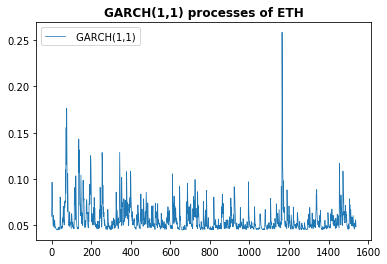

In [31]:
eth_sigma = run_garch(return_dataset.eth.to_numpy(), "ETH", 0.05)

Running Garch 1,1 model for XRP
Iteration:      1,   Func. Count:      4,   Neg. LLF: -2209.567443300443
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2209.567430293236
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
conf_int for XRP
             lower     upper  garchOneOne    Test
omega    -0.000099  0.000330     0.001000  Not ok
alpha[1] -0.045024  0.445024     0.546005  Not ok
beta[1]   0.459835  1.100165     0.401020  Not ok
          0
0  0.137393
1  0.092985
2  0.070056
3  0.069228
4  0.055705


C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005754. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


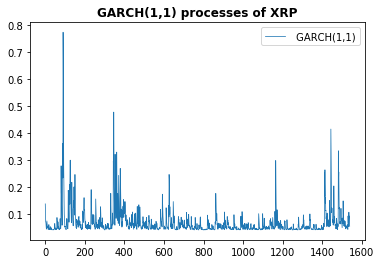

In [32]:
xrp_sigma = run_garch(return_dataset.xrp.to_numpy(), "XRP", 0.05)

In [33]:
gamma_vol_95 = pd.DataFrame({'btc': return_dataset.btc, 'vol_95_btc': btc_sigma,
              'eth': return_dataset.eth, 'vol_95_eth': eth_sigma,
              'xrp': return_dataset.xrp, 'vol_95_xrp': xrp_sigma})

In [34]:
gamma_vol_95.head()

,btc,vol_95_btc,eth,vol_95_eth,xrp,vol_95_xrp
0,0.021389,0.001784,0.149056,0.003587,0.011814,0.018877
1,0.100960,0.001763,0.145785,0.007534,0.028406,0.008646
2,-0.130575,0.001908,-0.092803,0.009340,-0.057803,0.004908
3,-0.116209,0.002078,0.000029,0.007582,0.018217,0.004792
4,0.007051,0.002094,-0.038521,0.004862,0.008044,0.003103


In [35]:
gamma_vol_95.to_csv('gammas.csv', index=False)  